## Show System Specifications

In [16]:
import scipy.io
import numpy as np
data = scipy.io.loadmat('MRI_anogan_input.mat')  # 读取mat文件
# data = scipy.io.loadmat('stand_my_input.mat')  # 读取mat文件


unseen2 = scipy.io.loadmat('unseen2.mat')  # 读取mat文件

test_img2 = unseen2['unseen2']
test_img2 = (test_img2.astype(np.float32) - 127.5) / 127.5

unseen1 = scipy.io.loadmat('unseen1.mat')  # 读取mat文件
test_img1 = unseen1['unseen1']
test_img1 = (test_img1.astype(np.float32) - 127.5) / 127.5

X_train = data['gg']
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

X_train = X_train[:,:,:,None]
X_train.shape


(2322, 84, 60, 1)

In [17]:
from __future__ import print_function

import matplotlib
#matplotlib.use('Qt5Agg')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import argparse
import anogan

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'




# parser = argparse.ArgumentParser()
# parser.add_argument('--img_idx', type=int, default=14)
# parser.add_argument('--label_idx', type=int, default=7)
# parser.add_argument('--mode', type=str, default='test', help='train, test')
# args = parser.parse_args()
args_mode = 't'
args_img_idx = 140
args_label_idx = 8

### 0. prepare data
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_test = (X_test.astype(np.float32) - 127.5) / 127.5

#X_test = X_test[:,:,:,None]

#X_test_original = X_test.copy()

#X_train = X_train[y_train==0]
#X_test = X_test[y_test==0]
print ('train shape:', X_train.shape)

### 1. train generator & discriminator
if args_mode == 'train':
  Model_d, Model_g = anogan.train(32, X_train)



train shape: (2322, 84, 60, 1)


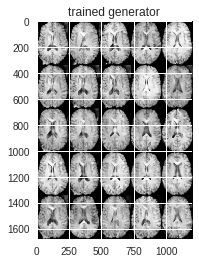

8 label, 140 : done 1160.44 14727.82ms
anomaly score :  1160.4371337890625


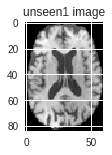

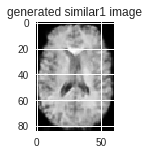

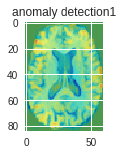

8 label, 140 : done 1015.03 16056.12ms
anomaly score :  1015.0333862304688


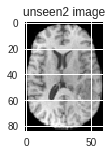

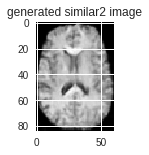

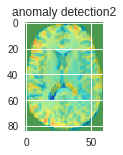

In [19]:
### 2. test generator
generated_img = anogan.generate(25)
img = anogan.combine_images(generated_img)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)

### opencv view
#cv2.namedWindow('generated', 0)
#cv2.resizeWindow('generated', 256, 256)
#cv2.imshow('generated', img)
cv2.imwrite('result_latent_10/generator.png', img)
#cv2.waitKey()

### plt view
plt.figure(num=0, figsize=(4, 4))
plt.title('trained generator')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

#exit()

### 3. other class anomaly detection


def anomaly_detection(test_img, g=None, d=None):
    model = anogan.anomaly_detector(g=g, d=d)
    ano_score, similar_img = anogan.compute_anomaly_score(model, test_img.reshape(1, 84, 60, 1), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(84,60,1) - similar_img.reshape(84,60,1)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(84,60,1)*127.5+127.5).astype(np.uint8)
    similar_x = (similar_img.reshape(84,60,1)*127.5+127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.4, residual_color, 0.6, 0.)

    return ano_score, original_x, similar_x, show


### compute anomaly score - sample from test set
# test_img = X_test_original[y_test==1][30]

### compute anomaly score - sample from strange image
# test_img = X_test_original[y_test==0][30]


### compute anomaly score - sample from strange image
img_idx = args_img_idx
label_idx = args_label_idx
#test_img = X_test_original[y_test==label_idx][img_idx]

# test_img = np.random.uniform(-1,1, (28,28,1))

start = cv2.getTickCount()
score, qurey, pred, diff = anomaly_detection(test_img1)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
print ('%d label, %d : done'%(label_idx, img_idx), '%.2f'%score, '%.2fms'%time)
cv2.imwrite('./qurey.png', qurey)
cv2.imwrite('./pred.png', pred)
cv2.imwrite('./diff.png', diff)

## matplot view
plt.figure(1, figsize=(2, 2))
plt.title('unseen1 image')
plt.imshow(qurey.reshape(84,60), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(2, 2))
plt.title('generated similar1 image')
plt.imshow(pred.reshape(84,60), cmap=plt.cm.gray)

plt.figure(3, figsize=(2, 2))
plt.title('anomaly detection1')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()




start = cv2.getTickCount()
score, qurey, pred, diff = anomaly_detection(test_img2)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
print ('%d label, %d : done'%(label_idx, img_idx), '%.2f'%score, '%.2fms'%time)
cv2.imwrite('./qurey.png', qurey)
cv2.imwrite('./pred.png', pred)
cv2.imwrite('./diff.png', diff)

## matplot view
plt.figure(1, figsize=(2, 2))
plt.title('unseen2 image')
plt.imshow(qurey.reshape(84,60), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(2, 2))
plt.title('generated similar2 image')
plt.imshow(pred.reshape(84,60), cmap=plt.cm.gray)

plt.figure(3, figsize=(2, 2))
plt.title('anomaly detection2')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

In [0]:

### 4. tsne feature view

### t-SNE embedding 
### generating anomaly image for test (radom noise image)

from sklearn.manifold import TSNE

random_image = np.random.uniform(0, 1, (100, 84, 60, 1))
print("random noise image")
plt.figure(4, figsize=(2, 2))
plt.title('random noise image')
plt.imshow(random_image[0].reshape(84,60), cmap=plt.cm.gray)

# intermidieate output of discriminator
model = anogan.feature_extractor()
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(X_test_original[y_test != 1][:300], verbose=1)
feature_map_of_minist_1 = model.predict(X_test[:100], verbose=1)

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist, feature_map_of_minist_1))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.figure(5)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100,0], X_embedded[:100,1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:400,0], X_embedded[100:400,1], label='mnist(anomaly)')
plt.scatter(X_embedded[400:,0], X_embedded[400:,1], label='mnist(normal)')
plt.legend()
plt.show()